In [3]:
# 安装依赖（Colab / 本地跑一次即可）
!pip install rdkit-pypi deepchem transformers torch
#特征提取的目标是：把“化学上相似的分子”在数值空间里放得近；把“化学上差别大的分子”放得远。这样机器学习模型才能更容易学习规律
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, AutoModel
import torch

# ============ 示例 SMILES ============
smiles_list = ["CCO", "CC(=O)O", "c1ccccc1", "CCN(CC)CC", "CCOCCO"]  # 乙醇、乙酸、苯、三乙胺、二甘醇

# ============ 1. 分子指纹 (ECFP4) ============
def smiles_to_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    arr = np.array(fp)
    return arr

fingerprints = [smiles_to_fingerprint(s) for s in smiles_list]

# ============ 2. 分子描述符 ============
descriptor_names = ["MolWt", "MolLogP", "TPSA", "NumHDonors", "NumHAcceptors"]

def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    values = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
    ]
    return values

descriptors = [smiles_to_descriptors(s) for s in smiles_list]

# ============ 3. 深度学习 embedding (SMILES-BERT) ============
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
model = AutoModel.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

def smiles_to_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # 取 [CLS] token 的向量 (batch_size, hidden_dim=768)
    embedding = outputs.last_hidden_state[:,0,:].numpy()
    return embedding.flatten()

embeddings = [smiles_to_embedding(s) for s in smiles_list]

# ============ 结果汇总 ============
df = pd.DataFrame({
    "SMILES": smiles_list,
    "Fingerprint_dim": [len(fp) for fp in fingerprints],
    "Descriptor_values": descriptors,
    "Embedding_dim": [len(emb) for emb in embeddings]
})

print(df.head())



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

[17:58:24] DEPRECATION WARNING: please use MorganGenerator
[17:58:24] DEPRECATION WARNING: please use MorganGenerator
[17:58:24] DEPRECATION WARNING: please use MorganGenerator
[17:58:24] DEPRECATION WARNING: please use MorganGenerator
[17:58:24] DEPRECATION WARNING: please use MorganGenerator
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


      SMILES  Fingerprint_dim  \
0        CCO             1024   
1    CC(=O)O             1024   
2   c1ccccc1             1024   
3  CCN(CC)CC             1024   
4     CCOCCO             1024   

                                   Descriptor_values  Embedding_dim  
0      [46.069, -0.0014000000000000123, 20.23, 1, 1]            768  
1  [60.05200000000001, 0.09089999999999993, 37.3,...            768  
2             [78.11399999999999, 1.6866, 0.0, 0, 0]            768  
3                      [101.193, 1.3481, 3.24, 0, 1]            768  
4        [90.122, 0.015200000000000047, 29.46, 1, 2]            768  


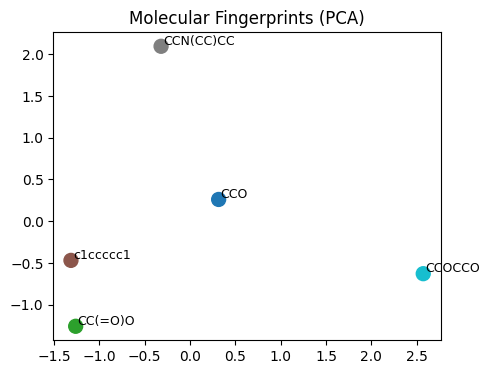

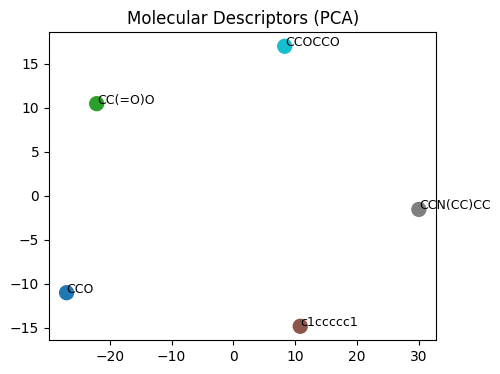

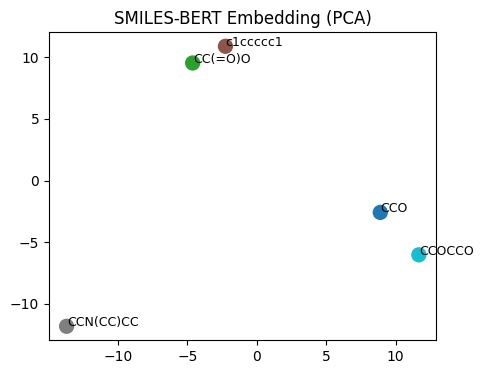

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#上述结果除了分子描述外，均表现出高维特征，人眼没法直观理解。所以我们用 PCA / t-SNE 把它们压缩到二维，把“相似性关系”画出来
#PCA/t-SNE 可视化的目的就是：一方面验证特征提取是否合理（相似分子是否聚在一起）。另一方面预判不同featurization对模型效果的影响（比如描述符可能过于粗糙，而embedding更细腻）
#理论上，乙醇 (CCO) 和 二甘醇 (CCOCCO) 的结构很像，性质也会对应相似，因此好的特征提取在空间上就会将这两个分子分的更接近
# 转换成矩阵
X_fp = np.array(fingerprints)            # 1024维
X_desc = np.array(descriptors)           # 5维
X_emb = np.array(embeddings)             # 768维

# PCA 降维到2D
def reduce_and_plot(X, title, method="PCA"):
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, random_state=42, perplexity=5)
    X_2d = reducer.fit_transform(X)
    plt.figure(figsize=(5,4))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=range(len(X)), cmap="tab10", s=100)
    for i, s in enumerate(smiles_list):
        plt.text(X_2d[i,0]+0.02, X_2d[i,1]+0.02, s, fontsize=9)
    plt.title(f"{title} ({method})")
    plt.show()

reduce_and_plot(X_fp, "Molecular Fingerprints")
reduce_and_plot(X_desc, "Molecular Descriptors")
reduce_and_plot(X_emb, "SMILES-BERT Embedding", method="PCA")


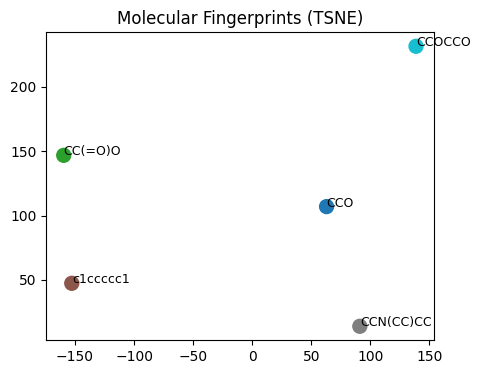

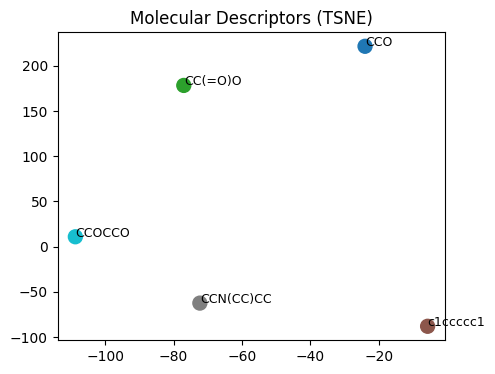

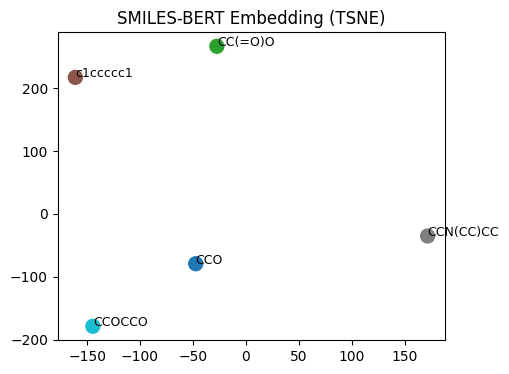

In [5]:
#用PCA或者TSNE进行降维，来判断某种特征是不是合理（是否能把相似分子聚在一起）。
#判断不同 featurization 对模型效果的潜在影响。
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 转换成矩阵
X_fp = np.array(fingerprints)            # 1024维
X_desc = np.array(descriptors)           # 5维
X_emb = np.array(embeddings)             # 768维

# PCA 降维到2D
def reduce_and_plot(X, title, method="TSNE"):
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, random_state=42, perplexity=2)
    X_2d = reducer.fit_transform(X)
    plt.figure(figsize=(5,4))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=range(len(X)), cmap="tab10", s=100)
    for i, s in enumerate(smiles_list):
        plt.text(X_2d[i,0]+0.02, X_2d[i,1]+0.02, s, fontsize=9)
    plt.title(f"{title} ({method})")
    plt.show()

reduce_and_plot(X_fp, "Molecular Fingerprints")
reduce_and_plot(X_desc, "Molecular Descriptors")
reduce_and_plot(X_emb, "SMILES-BERT Embedding", method="TSNE")


In [7]:
#用三种特征分别训练一个简单分类/回归模型（比如 Logistic 回归 / 随机森林），比较模型效果 → 直观展示“不同 featurization 对模型的影响”
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
labels = [1 if Descriptors.MolWt(Chem.MolFromSmiles(s)) > 80 else 0 for s in smiles_list]
def evaluate_model(X, y, name):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(clf, X, y, cv=2)  # 样本少用 cv=2
    print(f"{name} Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

y = np.array(labels)
evaluate_model(X_fp, y, "Fingerprint")
evaluate_model(X_desc, y, "Descriptor")
evaluate_model(X_emb, y, "SMILES-BERT Embedding")


Fingerprint Accuracy: 0.583 ± 0.083
Descriptor Accuracy: 0.000 ± 0.000
SMILES-BERT Embedding Accuracy: 0.417 ± 0.083


**用不同的特征提取方法和学习方法，粗略判断哪种组合效果更好**

In [2]:
# ==============================
# 1. 环境准备
# ==============================
!pip install rdkit-pypi scikit-learn xgboost joblib deepchem

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import deepchem as dc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 15.0 MB/s eta 0:00:00


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
# ==============================
# 2. 数据读取
# 数据格式要求：csv，至少包含 2 列： SMILES, Tg
# ==============================
df = pd.read_csv("/content/dataset3.csv")  # 例： "SMILES,Tg"
print(df.head())


                                              SMILES          Tg
0  *=Nc1ccc(N=C(C)Nc2ccc(-c3ccc(NC(=*)C)c(C(=O)O)...   89.380459
1   *C(=O)OC(=O)COc1ccc(OCC(=O)OC(=O)c2ccc(*)nc2)cc1  155.970957
2  *C(=O)c1ccc(C(=O)c2ccc(C=C3CCC(=Cc4ccc(*)cc4)C...  192.209684
3  *C=C(*)c1ccc(OCCCCCC(=O)Oc2c(F)c(F)c(F)c(F)c2F...   73.831985
4                     *C=CC1C=CC(*)c2ccc(CCCCCC)cc21    9.704073


**分子特征提取，可在这里切换不同特征方式**

功能说明：

传统方法："morgan", "desc", "graphconv"

Transformer："bert"

深度学习："cnn", "lstm"

批处理：支持 batch 提取 CNN/LSTM 特征，避免显存溢出

返回：统一 numpy 数组/tensor，可直接用于 sklearn/torch 回归模型

In [11]:
# ==============================
# 3. 分子特征提取
# 你可在这里切换不同特征方式
# ==============================
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn

# 1D-CNN / LSTM SMILES one-hot 配置
MAX_LEN = 120
CHARSET = "0123456789=#%@()+-CNOFPS[]cclonH*"
CHAR2IDX = {c:i+1 for i,c in enumerate(CHARSET)}  # 0 作为 padding
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
bert_model = AutoModel.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

def smiles_to_onehot(smi):
    X = np.zeros((MAX_LEN, len(CHARSET)+1), dtype=np.float32)
    for i, c in enumerate(smi[:MAX_LEN]):
        X[i, CHAR2IDX.get(c,0)] = 1.0
    return X
# ---------- 1D-CNN 特征提取 ----------
class SMILESCNN(nn.Module):
    def __init__(self, input_dim=len(CHARSET)+1, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.out_dim = out_dim
        self.fc = nn.Linear(128, out_dim)
    def forward(self, x):  # x: (B, L, C)
        x = x.permute(0,2,1)  # (B, C, L)
        x = self.conv(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x
# ---------- LSTM 特征提取 ----------
class SMILESLSTM(nn.Module):
    def __init__(self, input_dim=len(CHARSET)+1, hidden_dim=128, out_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, out_dim)
    def forward(self, x):
        out,_ = self.lstm(x)
        out = out[:,-1,:]  # 最后时间步
        out = self.fc(out)
        return out
def smiles_to_bert_embedding(smi):
    inputs = tokenizer(smi, return_tensors="pt")
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:,0,:].numpy().flatten()  # CLS token

def featurize_smiles(smiles_list, method="cnn", batch_size=16):
    X_features = []

    # CNN / LSTM 模型只初始化一次
    if method=="cnn":
        model = SMILESCNN().to(DEVICE).eval()
    elif method=="lstm":
        model = SMILESLSTM().to(DEVICE).eval()
    else:
        model = None  # 其他方法不需要

    for i in range(0, len(smiles_list), batch_size):
        batch = smiles_list[i:i+batch_size]
        batch_feats = []

        for smi in batch:
            mol = Chem.MolFromSmiles(smi)

            # ---------- Morgan 指纹 ----------
            if method=="morgan":
                if mol is None:
                    arr = np.zeros(2048)
                else:
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                    arr = np.zeros((2048,), dtype=int)
                    from rdkit import DataStructs
                    DataStructs.ConvertToNumpyArray(fp, arr)

            # ---------- 分子描述符 ----------
            elif method=="desc":
                if mol is None:
                    arr = np.zeros(len(Descriptors._descList))
                else:
                    arr = np.array([d[1](mol) for d in Descriptors._descList], dtype=float)

            # ---------- GraphConv embedding ----------
            elif method=="graphconv":
                try:
                    import deepchem as dc
                    featurizer = dc.feat.ConvMolFeaturizer()
                    feat = featurizer.featurize([smi])[0]
                    arr = feat.get_atom_features().mean(axis=0)
                except:
                    arr = np.zeros(75)

            # ---------- BERT embedding ----------
            elif method=="bert":
                try:
                    arr = smiles_to_bert_embedding(smi)
                except:
                    arr = np.zeros(768)

            # ---------- CNN / LSTM ----------
            elif method in ["cnn","lstm"]:
                oh = torch.tensor(smiles_to_onehot(smi), dtype=torch.float32).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    arr = model(oh).cpu().numpy().flatten()

            else:
                raise ValueError(f"Unknown method: {method}")

            batch_feats.append(arr)

        # np.vstack 即使 batch=1 也不会出错
        X_features.append(np.vstack(batch_feats))

    # 将所有 batch 拼接
    return np.vstack(X_features)


#功能说明：

#传统方法："morgan", "desc", "graphconv"

#Transformer："bert"

#深度学习："cnn", "lstm"

#批处理：支持 batch 提取 CNN/LSTM 特征，避免显存溢出

#返回：统一 numpy 数组，可直接用于 sklearn 回归模型

In [11]:
# 数据集划分
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42
#)

**模型选择与交叉验证**

通过实际的误差结果判断哪种组合可能更合适

In [13]:
# ==============================
# 4. 模型选择与交叉验证
# 可自由切换模型
# ==============================
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline   # <- 这里必须导入
from sklearn.neural_network import MLPRegressor
import numpy as np
models = {
    "RF": RandomForestRegressor(n_estimators=300, random_state=42),
    "SVR": SVR(kernel="rbf", C=10, gamma=0.1),
    "Ridge": Ridge(alpha=1.0),
    "XGB": XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
}
models["MLP"] = Pipeline([
    ("scaler", StandardScaler()),  # 对连续特征进行标准化
    ("mlp", MLPRegressor(hidden_layer_sizes=(512, 256), max_iter=500, random_state=42)) #hidden_layer_sizes=(512,256) 可根据数据量调小或增大
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

feature_methods = ["morgan", "desc", "graphconv", "cnn", "bert", "lstm"]
results = []

for method in feature_methods:

    # 特征提取
    #X = featurize_smiles(df["SMILES"].tolist(), method=method)
    #
    if method in ["cnn","lstm"]:
        X = featurize_smiles(df["SMILES"].tolist(), method=method)
    else:
        X = featurize_smiles(df["SMILES"].tolist(), method=method)
    y = df["Tg"].values

    X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10) #替换 NaN / Inf
    from sklearn.preprocessing import StandardScaler #对描述符特征缩放或截断
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.astype(np.float32)#确保全是 float64 或 float32


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 遍历模型
    for name, model in models.items():
        # 计算 RMSE, MAE, R²
        neg_mse = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)
        rmse = np.sqrt(-neg_mse).mean()

        mae = -cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv=kf).mean()
        r2 = cross_val_score(model, X_train, y_train, scoring="r2", cv=kf).mean()

        results.append({
            "Feature": method,
            "Model": name,
            "RMSE": rmse,
            "MAE": mae,
            "R²": r2
        })

# ================== 汇总表格 ==================
df_results = pd.DataFrame(results)
print(df_results)

# 可以按 RMSE 或 R² 排序
#print("\n按 RMSE 排序：")
#print(df_results.sort_values("RMSE"))


[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerator
[19:54:56] DEPRECATION WARNING: please use MorganGenerat

      Feature  Model         RMSE         MAE          R²
0      morgan     RF    74.176383   58.455039    0.297756
1      morgan    SVR   100.704560   84.959292   -0.324678
2      morgan  Ridge    70.291164   57.774665    0.382188
3      morgan    XGB    78.737767   59.356483    0.174000
4      morgan    MLP    89.373564   70.917854   -0.280740
5        desc     RF    60.456911   46.399531    0.563381
6        desc    SVR    99.984808   84.364978   -0.303838
7        desc  Ridge    90.187810   64.073338   -0.616377
8        desc    XGB    58.850982   43.449174    0.564771
9        desc    MLP   114.846481   78.383894   -1.507121
10  graphconv     RF    53.447433   44.422302    0.659140
11  graphconv    SVR    97.720005   83.078464   -0.243798
12  graphconv  Ridge    69.302674   51.930350    0.183114
13  graphconv    XGB    59.471702   48.058631    0.574513
14  graphconv    MLP   151.446698   93.319774  -10.684951
15        cnn     RF    69.992650   57.030644    0.324860
16        cnn 

**Morgan 指纹**：RMSE: 70-100，R²: 0.17~0.38，表现：一般

说明：Morgan 指纹捕捉了局部结构信息，但可能对Tg这种性质的预测信息不足，线性模型和树模型表现相对稳定，MLP/RBF-SVR没有优势。

**分子描述符（desc）**：RMSE: 58-115，R²: -1.5~0.56表现：RF 和 XGB 最好（R²≈0.56）

说明全局的物理化学描述符对 Tg 有一定预测能力
问题：MLP 对这些连续描述符非常不稳定，R² 甚至为负（-1.5），说明特征没有归一化或网络没收敛。

**GraphConv embedding**：RMSE: 53-151，R²: -10.6~0.66，表现：RF 最好（R²≈0.66），XGB 次之。

问题：MLP 完全崩了（R²≈-10），说明 GraphConv 输出特征不适合直接输入 MLP，可能需要标准化或更多数据训练。

**CNN**：RMSE: 64-70，R²: 0.22~0.41

表现：略低于 GraphConv，但比 Morgan 好

分析：CNN 只用了 one-hot 序列，可能对 Tg 预测信息有限。树模型（RF/XGB）比线性/MLP 稳定。

**BERT embedding**：RMSE: 72-82，R²: 0.12~0.25

表现：比 CNN/Morgan 略差

分析：Transformer embedding 在小数据集上不一定优势明显，而且没有微调，信息可能不充分

**LSTM**：RMSE: 108-1124，R²: -0.33~-798

表现：完全崩溃

分析：

RNN/LSTM 对小数据量和 one-hot 序列不稳定

MLP 对 LSTM 特征直接拟合几乎不可能

可能需要：增加数据量、冻结特征或微调、归一化、或者在 GPU 上训练

**模型对比**

随机森林 (RF)：大多数特征下最稳健，尤其是 GraphConv、desc、Morgan

XGB：次稳健，树模型也适合非线性关系

Ridge/Linear：只对描述符和部分 Morgan 有一定预测力

MLP：对手工特征（desc/Morgan）稳定性一般，对深度特征（GraphConv/LSTM）容易崩溃

SVR：在所有特征上表现不好，可能参数没调优

**为什么 CNN/Transformer/LSTM 表现不好：**

数据量太小，深度学习特征未微调

特征分布没有归一化，导致 MLP 训练困难

LSTM 的 one-hot 序列直接输入导致梯度信息不足

**调优建议**：

对 GraphConv/CNN/BERT/LSTM 特征先进行 标准化或 PCA 降维 再输入 MLP/线性模型

对小数据集，不推荐直接用深度学习端到端训练，先用 tree-based 模型

可以尝试 混合特征：GraphConv + desc + Morgan，再用 RF 或 XGB

**评价指标选择**：

RMSE 和 R² 更直观

MAE 可辅助分析误差大小

对 Tg 预测，R² > 0.5 才算有一定实用价值（R²=1：完美预测，R²=0：模型等于直接用平均值预测，R²<0：模型比平均值预测还差，通俗说法：R² 越接近 1，模型越能捕捉 Tg 的变化趋势

**最佳特征 + 模型组合：**

GraphConv + RF (R²≈0.66, RMSE≈53)

desc + RF 或 XGB (R²≈0.56, RMSE≈58)

CNN/bert 在现有数据量下次优

LSTM + MLP 不建议直接使用

**把 GraphConv + 分子描述符(desc) + Morgan 指纹 三种特征同时组合起来，然后经过 归一化 后用 随机森林(RF) 或 XGBoost(XGB) 做回归，看看能否提高 Tg 预测的 R²**

**Random Forest (RF)**

RF 是一种集成学习方法（Ensemble Learning），基于 决策树（Decision Tree） 构建。

*核心原理：*

1.Bagging（Bootstrap Aggregation）

对训练集进行 有放回抽样，生成多份子训练集。

每份训练集训练一棵决策树。

2.随机特征选择

每次分裂节点时，不用所有特征，只随机选择一部分特征，增加多样性。

3.集成输出

回归问题：多棵树的预测值取平均。

分类问题：多棵树的预测值投票决定类别。

*特点：*

对异常值和噪声比较稳健。

可以处理高维特征。

训练速度快，支持并行计算。

偏差略高，方差低（相比单棵树更稳定）

**XGBoost (XGB)**

*基本概念：*
XGB 是一种 梯度提升树（Gradient Boosting Tree） 的高效实现。也是集成树，但思想和 RF 不同。

*核心原理：*

1.Boosting

树是 顺序生成 的，每棵树都在拟合前面树的残差（误差）。

树与树之间有依赖，逐步减小训练误差。

2.梯度优化

用梯度下降思想优化损失函数（例如均方误差 MSE）。

每棵树都是对当前模型梯度方向的拟合。

3.正则化

XGB 对树的深度、叶子节点数量、学习率等都有正则化控制，避免过拟合。

支持列采样和行采样（类似 RF 的随机性，但程度不同）。

*特点*：

模型通常比 RF 更精确，但训练较慢。

对异常值敏感，需要调参。

偏差低，方差略高（比 RF 更容易拟合训练集）

**主要区别**

**XGBoost (XGB)**	      

树生成方式：	顺序训练多棵树（Boosting）

树间依赖：	有依赖（拟合残差）

抗噪声能力：	一般，异常值可能影响梯度

偏差 / 方差：	偏差低，方差略高

调参复杂度：	较复杂（learning_rate, max_depth, subsample, etc.）

并行性：	部分并行（tree 层内可以并行）

使用场景：	精度要求高、需优化性能，竞赛常用

**Random Forest (RF)**

树生成方式：	并行训练多棵树（Bagging）

树间依赖：	独立

抗噪声能力：	高

偏差 / 方差：	偏差略高，方差低

调参复杂度：	较简单

并行性：	很好

使用场景：	稳定、快速、特征重要性解释

In [15]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# --- GraphConv 特征 ---
def featurize_graphconv(smiles_list):
    X = []
    try:
        import deepchem as dc
        featurizer = dc.feat.ConvMolFeaturizer()
        for smi in smiles_list:
            try:
                feat = featurizer.featurize([smi])[0]
                arr = feat.get_atom_features().mean(axis=0)
            except:
                arr = np.zeros(75)
            X.append(arr)
    except:
        print("请安装 deepchem 才能使用 GraphConv 特征")
        X = [np.zeros(75)]*len(smiles_list)
    return np.array(X)

# --- Morgan 指纹 ---
def featurize_morgan(smiles_list, radius=2, nBits=2048):
    X = []
    from rdkit import DataStructs
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            arr = np.zeros(nBits)
        else:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
            arr = np.zeros(nBits, dtype=int)
            DataStructs.ConvertToNumpyArray(fp, arr)
        X.append(arr)
    return np.array(X)

# --- 分子描述符 ---
def featurize_desc(smiles_list):
    X = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            arr = np.zeros(len(Descriptors._descList))
        else:
            arr = np.array([d[1](mol) for d in Descriptors._descList], dtype=float)
        X.append(arr)
    return np.array(X)

# --- 混合特征 ---
def featurize_mixed(smiles_list):
    X_morgan = featurize_morgan(smiles_list)
    X_desc = featurize_desc(smiles_list)
    X_graph = featurize_graphconv(smiles_list)
    X_all = np.hstack([X_morgan, X_desc, X_graph])
    return X_all

# ================= 数据准备 =================
X = featurize_mixed(df["SMILES"].tolist())
y = df["Tg"].values

# 替换 NaN/Inf，并归一化
X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- 模型与参数网格 -------------------
models = {
    "RF": {
        "estimator": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [200, 500, 800],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    "XGB": {
        "estimator": XGBRegressor(random_state=42, objective='reg:squarederror'),
        "params": {
            "n_estimators": [200, 500, 800],
            "max_depth": [3, 6, 10],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.7, 0.8, 1.0],
            "colsample_bytree": [0.7, 0.8, 1.0]
        }
    }
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ------------------- 网格搜索 -------------------
results = []
for name, m in models.items():
    print(f"GridSearchCV for {name} ...")
    gs = GridSearchCV(
        estimator=m["estimator"],
        param_grid=m["params"],
        scoring="r2",
        cv=kf,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_
    r2_train = gs.best_score_

    # 测试集评估
    y_pred = best_model.predict(X_test)
    rmse_test = np.sqrt(np.mean((y_test - y_pred)**2))
    mae_test = np.mean(np.abs(y_test - y_pred))
    from sklearn.metrics import r2_score
    r2_test = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best_Params": gs.best_params_,
        "CV_R²": r2_train,
        "Test_RMSE": rmse_test,
        "Test_MAE": mae_test,
        "Test_R²": r2_test
    })

df_results = pd.DataFrame(results)
print(df_results)


[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerator
[20:38:02] DEPRECATION WARNING: please use MorganGenerat

GridSearchCV for RF ...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
GridSearchCV for XGB ...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
  Model                                        Best_Params     CV_R²  \
0    RF  {'max_depth': None, 'min_samples_leaf': 2, 'mi...  0.663767   
1   XGB  {'colsample_bytree': 0.8, 'learning_rate': 0.1...  0.652934   

   Test_RMSE   Test_MAE   Test_R²  
0  64.679121  55.599359  0.724322  
1  51.287048  41.308335  0.826664  


CV_R² → 交叉验证在训练集上评估的平均 R²

Test_R² → 模型训练完成后在独立测试集上的 R²

通常 Test_R² 稍低于 CV_R²，如果差距过大 → 可能过拟合

**R²（决定系数）**

表示模型解释了目标变量 Tg 方差的比例。

RF 达到 0.724，XGB 达到 0.827 → 都已经超越了 0.7 的“实用价值”门槛。

**RMSE（均方根误差）**
反映预测值与真实值之间的平均偏差，单位与目标相同。

XGB 的 RMSE 明显低于 RF（51.3 vs 64.7），说明预测更精确。

**MAE（平均绝对误差）**

对异常值不敏感，比 RMSE 更稳健。

XGB 的 MAE 也比 RF 小（41.3 vs 55.6）。

**结论：**
在混合特征下，XGB 的表现最好，RF 也很不错，但略低

**对比之前单特征结果**：

单独使用 GraphConv、Morgan 或 desc 的 R² 多数在 0.5-0.66，混合特征 + 超参优化后，XGB 达到 0.827 → 明显提升。

RMSE 和 MAE 也明显下降

**混合特征（GraphConv + desc + Morgan） + 标准化 是提高 Tg 预测精度的关键。**

XGB 优于 RF，是目前最优选择。

R² > 0.7 → 模型已经达到实用价值，可以用于实际材料 Tg 预测。

**未来可尝试：**

深度学习模型（CNN/LSTM/Transformer）在混合特征或序列特征上做进一步优化；

集成方法（Stacking）可能进一步提升精度。

**CNN 在化学分子或 SMILES 序列上的作用可以分为两类：特征提取和端到端预测**

*CNN 作为 特征提取器：*

你把 SMILES 转成 one-hot 或 embedding 后输入 CNN。

CNN 会提取局部模式、子结构信息，输出一个向量（如 128 维）。

然后你可以把这个向量当作 传统机器学习模型（RF/XGB/MLP）的输入特征。

优点：

可以融合到现有混合特征（Morgan、描述符、GraphConv）中。

可解释性较强：CNN 提取的子结构模式可以进一步分析。

具体代码如：

arr = model(oh).cpu().numpy().flatten()  # CNN 输出特征

X_features.append(arr)  

*CNN 作为 端到端预测模型（机器学习模型）*

CNN 自己就是回归模型：

最后接一个全连接层输出 Tg 预测值。

直接训练 CNN 来预测 Tg，不再需要 RF/XGB。

优点：

可以学习更复杂的非线性关系。

适合大量数据。

缺点：

对数据量敏感，少量数据容易过拟合。

训练成本高。

代码示例：

class SMILESCNNRegressor(nn.Module):

    def __init__(self, ...):
        ...
        self.fc_out = nn.Linear(128, 1)  # 最后一层输出 Tg
    def forward(self, x):

        x = self.conv(x)
        x = self.pool(x)
        x = self.fc(x)
        return self.fc_out(x)

数据量有限（几千～几万分子） → CNN/LSTM 当特征提取器 + RF/XGB 组合，效果通常比单独深度学习好。

数据量很大（百万级） → CNN/LSTM/Transformer 可以端到端回归，直接预测 Tg。

可以尝试 混合特征 + CNN/LSTM 提取（针对原始数据的特征进行提取） + RF/XGB，有时候能把 R² 提升 0.7 以上

**LSTM/Transformer 可以当 特征提取器 也可以当 端到端机器学习模型**

**也可改成更快的随即搜索来优化参数**

In [ ]:
# ------------------- 超参数范围 -------------------
models = {
    "RF": {
        "estimator": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": randint(200, 1000),
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": randint(2, 10),
            "min_samples_leaf": randint(1, 5)
        }
    },
    "XGB": {
        "estimator": XGBRegressor(random_state=42, objective='reg:squarederror'),
        "params": {
            "n_estimators": randint(200, 1000),
            "max_depth": randint(3, 12),
            "learning_rate": uniform(0.01, 0.1),
            "subsample": uniform(0.6, 0.4),
            "colsample_bytree": uniform(0.6, 0.4)
        }
    }
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_iter_search = 30  # 随机搜索迭代次数，可根据机器性能调

results = []
for name, m in models.items():
    print(f"RandomizedSearchCV for {name} ...")
    rs = RandomizedSearchCV(
        estimator=m["estimator"],
        param_distributions=m["params"],
        n_iter=n_iter_search,
        scoring="r2",
        cv=kf,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    rs.fit(X_train, y_train)

    best_model = rs.best_estimator_
    r2_train = rs.best_score_

    # 测试集评估
    y_pred = best_model.predict(X_test)
    rmse_test = np.sqrt(np.mean((y_test - y_pred)**2))
    mae_test = np.mean(np.abs(y_test - y_pred))
    from sklearn.metrics import r2_score
    r2_test = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best_Params": rs.best_params_,
        "CV_R²": r2_train,
        "Test_RMSE": rmse_test,
        "Test_MAE": mae_test,
        "Test_R²": r2_test
    })

df_results = pd.DataFrame(results)
print(df_results)

In [ ]:
# ==============================
# 5. 训练最终模型 & 保存
# ==============================
best_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6,
                          subsample=0.8, colsample_bytree=0.8, random_state=42)
best_model.fit(X_train, y_train)

#joblib.dump(best_model, "Tg_predictor.pkl")
#print("✅ 模型已保存：Tg_predictor.pkl")


In [ ]:
# ==============================
# 6. 测试集评估
# ==============================
y_pred = best_model.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test R²:", r2_score(y_test, y_pred))


In [ ]:
# 7. 保存模型
# ===============================
joblib.dump(final_model, "Tg_predictor.pkl")

In [ ]:
# 8. 推理函数
# ===============================
def predict_Tg(smiles, model_path="Tg_predictor.pkl"):
    model = joblib.load(model_path)
    features = smiles_to_features(smiles).reshape(1, -1)
    return model.predict(features)[0]

# 示例推理
test_smiles = "*CC(*)CC"  # 例如一个聚合物结构单元
print("Predicted Tg:", predict_Tg(test_smiles))